<a href="https://colab.research.google.com/github/146790g/TextBook-colab_tfbook/blob/master/CIFAR10_VGG16_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 VGG16 Model





Note: This notebook is desinged to run with Python3 and GPU runtime.

![Python 3 and CPU runtime](https://raw.githubusercontent.com/enakai00/colab_tfbook/master/docs/imgs/runtime_gpu.png)

This notebook uses TensorFlow 2.x.

In [ ]:
%tensorflow_version 2.x

####[CCC-01]
Import modules and set a random seed.

In [ ]:
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10

import os
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np

np.random.seed(20190610)
tf.random.set_seed(20190610)

Using TensorFlow backend.


####[CCC-02]
Download the CIFAR10 dataset and store into NumPy arrays.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

170500096/170498071 [==============================] - 6s 0us/step


# Data Inspection

####[CCC-03]
Show sample images for each category.

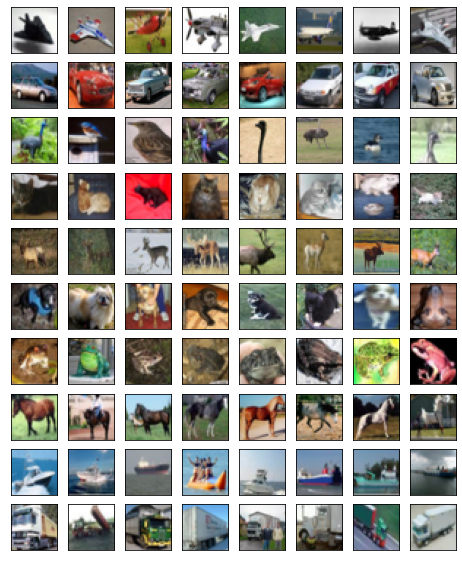

In [ ]:
fig = plt.figure(figsize=(8, 10))
c = 0
for i in range(10):
    for j in range(len(train_images)):
        if np.argmax(train_labels[j]) == i:
            c += 1
            subplot = fig.add_subplot(10, 8, c)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.imshow(train_images[j])
            if c % 8 == 0:
                break

####[CCC-04]
Define the image data generator.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    channel_shift_range=0.2)

####[CCC-05]
Show some generated images for each category.

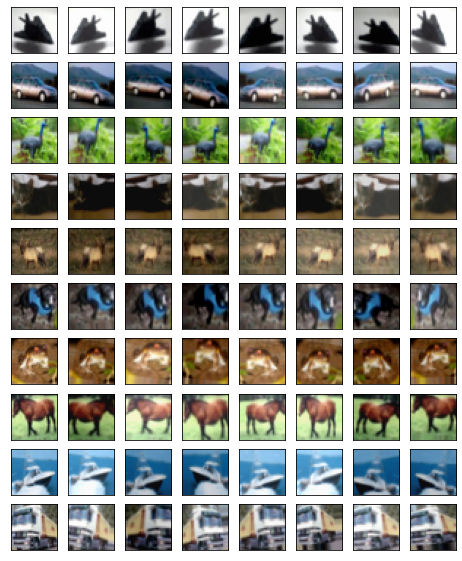

In [ ]:
fig = plt.figure(figsize=(8, 10))
c = 0
for i in range(10):
    for j in range(len(train_images)):
        if np.argmax(train_labels[j]) == i:
            break
    c += 1
    subplot = fig.add_subplot(10, 8, c)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(train_images[j])

    for _ in range(7):
        img = datagen.flow(np.array([train_images[j]]), batch_size=1)[0][0]
        c += 1
        subplot = fig.add_subplot(10, 8, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(img)

####[CCC-06]
Define a VGG16 model.

In [ ]:
## VGG16モデルと学習済み重みを読み込む
vgg16_model = VGG16(include_top=False,        # 全結合層は層（FC）は読み込まない
                    weights='imagenet',       # ImageNetで学習した重みを利用
                    input_shape=(32, 32, 3) # 入力データの形状
                   )
# VGG16モデルのサマリを出力
print('VGG16モデルのサマリ')
vgg16_model.summary()

# VGG16のblock1_conv1からblock4_poolまでを凍結
# block5のみを学習可能にする
vgg16_model.trainable = True
set_trainable = False
for layer in vgg16_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:        
        layer.trainable = True
    else:
        layer.trainable = False
    
## 凍結後のサマリを出力
print('凍結後のサマリ')
vgg16_model.summary()

## VGG16モデルと独自のFC層を連結した計算モデルを構築
# Sequentialオブジェクトを生成
model = Sequential()

# VGG16モデルを追加
model.add(vgg16_model)
# Flatten層
model.add(Flatten())
# 全結合層
model.add(Dense(256,                 # ニューロン数は256
                activation='relu'    # 活性化関数はReLU
                ))
#第８層（出力層）
model.add(Dense(10, activation='softmax', name='softmax'))

# VGG16に独自のFC層を結合したモデルのサマリを出力
print('結合後のサマリ')
model.summary()

## モデルのコンパイル
# 最適化はRMSpropで行う
# 学習率を小さくしたのはファインチューニングを


58892288/58889256 [==============================] - 2s 0us/step
VGG16モデルのサマリ
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________

####[CCC-07]
Compile the model using the Adam optimizer, and the cross entroy as a loss function.

In [ ]:
## モデルのコンパイル
# 最適化はRMSpropで行う
# 学習率を小さくしたのはファインチューニングを

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

####[CCC-08]
Train the model. It achieves the 95.18% accuracy.

In [ ]:
batch_size = 64
history = model.fit_generator(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    validation_data=(test_images, test_labels),
    steps_per_epoch=len(train_images) / batch_size,
    epochs=20)

Epoch 1/20
782/781 [==============================] - 39s 50ms/step - loss: 0.2261 - accuracy: 0.9153 - val_loss: 0.1785 - val_accuracy: 0.9309
Epoch 2/20
782/781 [==============================] - 33s 42ms/step - loss: 0.1797 - accuracy: 0.9301 - val_loss: 0.1620 - val_accuracy: 0.9362
Epoch 3/20
782/781 [==============================] - 33s 42ms/step - loss: 0.1673 - accuracy: 0.9348 - val_loss: 0.1509 - val_accuracy: 0.9411
Epoch 4/20
782/781 [==============================] - 32s 41ms/step - loss: 0.1593 - accuracy: 0.9372 - val_loss: 0.1481 - val_accuracy: 0.9417
Epoch 5/20
782/781 [==============================] - 33s 42ms/step - loss: 0.1538 - accuracy: 0.9397 - val_loss: 0.1472 - val_accuracy: 0.9422
Epoch 6/20
782/781 [==============================] - 32s 41ms/step - loss: 0.1493 - accuracy: 0.9417 - val_loss: 0.1380 - val_accuracy: 0.9452
Epoch 7/20
782/781 [==============================] - 33s 42ms/step - loss: 0.1454 - accuracy: 0.9431 - val_loss: 0.1324 - val_accuracy:

####[CCC-09]
Plot chars for accuracy and loss values.

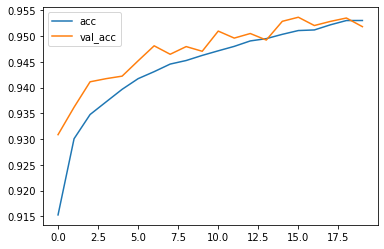

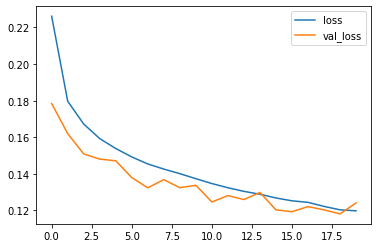

In [ ]:
DataFrame({'acc': history.history['accuracy'], 
           'val_acc': history.history['val_accuracy']}).plot()
DataFrame({'loss': history.history['loss'], 
           'val_loss': history.history['val_loss']}).plot()